<a href="https://colab.research.google.com/github/pethodoma/BME-DeepLearning-BirdCLEF_2023/blob/main/Custom_datagenerator_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
import librosa
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
!wget -O training_files.zip https://www.dropbox.com/scl/fi/xefxidhnea3t6l5pkq6he/atleast_500.zip?rlkey=qe01cuxklk6ge1irpqarq7eoq&dl=0
!wget -O atleast_500.csv https://www.dropbox.com/scl/fi/tvoxpxnsolwv58fouk51o/atleast_500.csv?rlkey=m8uhqea3mysnpnjtc0aptkl93&dl=0

--2023-12-03 16:47:57--  https://www.dropbox.com/scl/fi/xefxidhnea3t6l5pkq6he/atleast_500.zip?rlkey=qe01cuxklk6ge1irpqarq7eoq
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6057:18::a27d:d12
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc07bf9076afef1861443f05d8c5.dl.dropboxusercontent.com/cd/0/inline/CIvX9lmPWL37PmYlAOxZrVYfNGmfrdiHGdlXSxgCVkECJLUpwluZv5pDiNHivcP5PqqsG64g-3YJ9cSBQgZfK3RvwhqgWKBfqkMwX2gPPijg9B49kr3Tcs4IsKgPNgIX-HEWHGuXMdwJwv3p3cZZl0Wv/file# [following]
--2023-12-03 16:47:58--  https://uc07bf9076afef1861443f05d8c5.dl.dropboxusercontent.com/cd/0/inline/CIvX9lmPWL37PmYlAOxZrVYfNGmfrdiHGdlXSxgCVkECJLUpwluZv5pDiNHivcP5PqqsG64g-3YJ9cSBQgZfK3RvwhqgWKBfqkMwX2gPPijg9B49kr3Tcs4IsKgPNgIX-HEWHGuXMdwJwv3p3cZZl0Wv/file
Resolving uc07bf9076afef1861443f05d8c5.dl.dropboxusercontent.com (uc07bf9076afef1861443f05d8c5.dl.dropboxusercontent.com)... 162.125.8.15, 2

In [3]:
!unzip 'training_files.zip'

A streamkimeneten csak az utolsó 5000 sor látható.
  inflating: wlwwar/wlwwar_1526.wav  
  inflating: wlwwar/wlwwar_1527.wav  
  inflating: wlwwar/wlwwar_1528.wav  
  inflating: wlwwar/wlwwar_1529.wav  
  inflating: wlwwar/wlwwar_153.wav   
  inflating: wlwwar/wlwwar_1530.wav  
  inflating: wlwwar/wlwwar_1531.wav  
  inflating: wlwwar/wlwwar_1532.wav  
  inflating: wlwwar/wlwwar_1533.wav  
  inflating: wlwwar/wlwwar_1534.wav  
  inflating: wlwwar/wlwwar_1535.wav  
  inflating: wlwwar/wlwwar_1536.wav  
  inflating: wlwwar/wlwwar_1537.wav  
  inflating: wlwwar/wlwwar_1538.wav  
  inflating: wlwwar/wlwwar_1539.wav  
  inflating: wlwwar/wlwwar_154.wav   
  inflating: wlwwar/wlwwar_1540.wav  
  inflating: wlwwar/wlwwar_1541.wav  
  inflating: wlwwar/wlwwar_1542.wav  
  inflating: wlwwar/wlwwar_1543.wav  
  inflating: wlwwar/wlwwar_1544.wav  
  inflating: wlwwar/wlwwar_1545.wav  
  inflating: wlwwar/wlwwar_1546.wav  
  inflating: wlwwar/wlwwar_1547.wav  
  inflating: wlwwar/wlwwar_1548.wav  

In [4]:
def read_file_paths(main_directory):
    main_directory = main_directory
    file_paths = []

    # go through all folders and get the paths of all .ogg audio files
    for root, directories, files in os.walk(main_directory):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                file_paths.append(file_path)

    # os.walk may not go in alphabetical order thus it needs to be sorted
    file_paths.sort()
    return file_paths

In [5]:
# Creating the dict with the numerical categoris to each filepath
filepaths = read_file_paths(os.getcwd())
df = pd.read_csv('atleast_500.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df['Category'] = range(len(df))
labels = {filename: df[df['Bird'] == filename.split(os.path.sep)[-2]]['Category'].values[0] for filename in filepaths}

In [6]:
train_paths, test_paths = train_test_split(filepaths, test_size=0.2, random_state=42)
partition = {'train': train_paths, 'test': test_paths}

In [8]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(128, 313), n_channels=1,
                 n_classes=30, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            audio, sr = librosa.load(ID, sr=None)
            spec = librosa.feature.melspectrogram(y=audio, sr=sr)
            spec_db = librosa.power_to_db(spec, ref=np.max)
            spec_normalized = (spec_db - spec_db.min()) / (spec_db.max() - spec_db.min())
            X[i,] = spec_normalized.reshape((*self.dim, self.n_channels))

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [11]:
tg = DataGenerator(partition['train'], labels, batch_size=1)
x, y = tg._DataGenerator__data_generation(partition['train'][:1])
x.shape

(1, 128, 313, 1)

In [14]:
training_generator = DataGenerator(partition['train'], labels, batch_size=64)
validation_generator = DataGenerator(partition['test'], labels, batch_size=64)

In [15]:
checkpoint = keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')


In [16]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (5,5), activation='relu', input_shape=(128, 313, 1)))
model.add(keras.layers.Conv2D(16, (5,5), activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(30, activation='softmax'))

In [17]:
model.compile('Adam', loss='CategoricalCrossentropy', metrics=['accuracy', 'categorical_crossentropy', keras.metrics.Precision(), keras.metrics.Recall()])

In [18]:
num_epochs = 4

history = model.fit(x=training_generator,
                    epochs=num_epochs,
                    validation_data=validation_generator,
                    callbacks=[checkpoint],
                    workers=4,  # Adjust the number of workers based on your system capabilities
                    use_multiprocessing=True)

model.save('final_model.h5')

Epoch 1/4
593/593 [==============================] - ETA: 0s - loss: 2.0662 - accuracy: 0.5037 - categorical_crossentropy: 2.0662 - precision: 0.8117 - recall: 0.3199

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


593/593 [==============================] - 1044s 2s/step - loss: 2.0662 - accuracy: 0.5037 - categorical_crossentropy: 2.0662 - precision: 0.8117 - recall: 0.3199 - val_loss: 1.2912 - val_accuracy: 0.6427 - val_categorical_crossentropy: 1.2912 - val_precision: 0.8317 - val_recall: 0.5020
Epoch 2/4
593/593 [==============================] - 1044s 2s/step - loss: 0.9198 - accuracy: 0.7458 - categorical_crossentropy: 0.9198 - precision: 0.8868 - recall: 0.6352 - val_loss: 1.1339 - val_accuracy: 0.6855 - val_categorical_crossentropy: 1.1339 - val_precision: 0.8521 - val_recall: 0.5674
Epoch 3/4
593/593 [==============================] - 1078s 2s/step - loss: 0.3984 - accuracy: 0.8882 - categorical_crossentropy: 0.3984 - precision: 0.9441 - recall: 0.8409 - val_loss: 1.2701 - val_accuracy: 0.6850 - val_categorical_crossentropy: 1.2701 - val_precision: 0.7728 - val_recall: 0.6372
Epoch 4/4
593/593 [==============================] - 1025s 2s/step - loss: 0.1177 - accuracy: 0.9679 - categorica

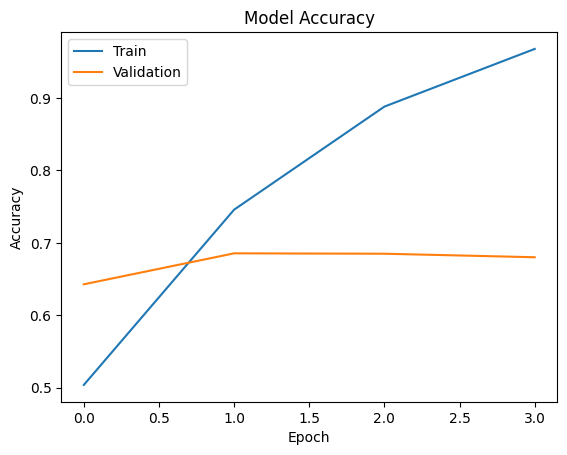

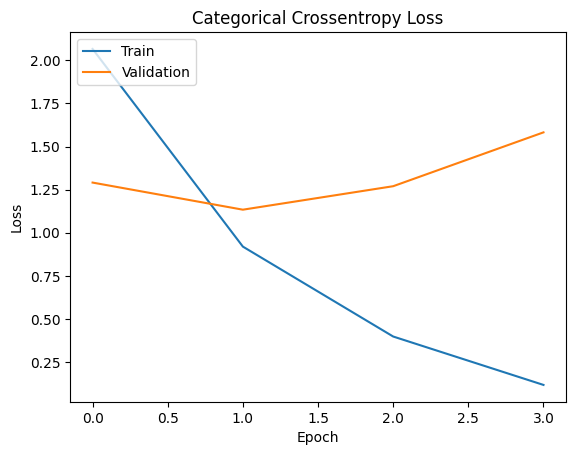

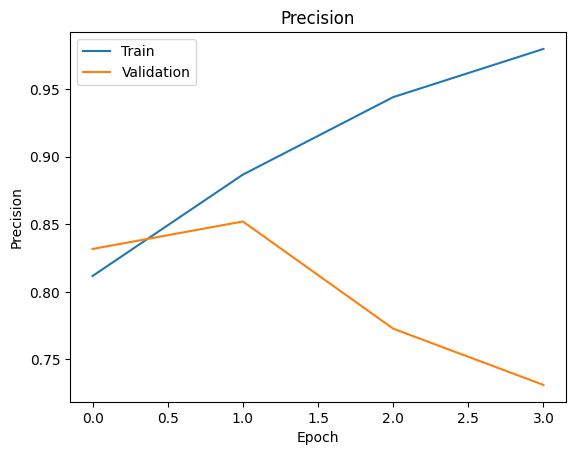

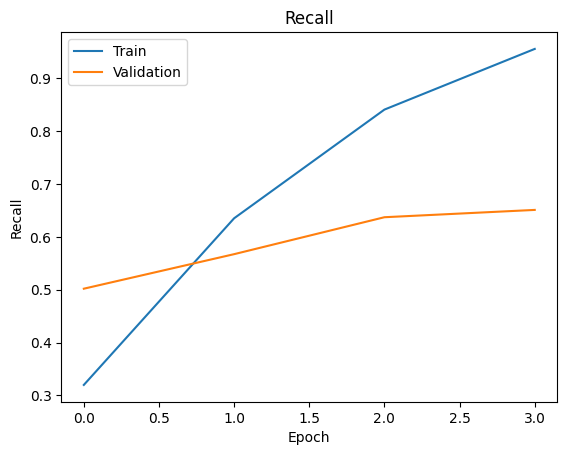

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['categorical_crossentropy'])
plt.plot(history.history['val_categorical_crossentropy'])
plt.title('Categorical Crossentropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation precision values
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation recall values
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()